In [1]:
%matplotlib inline

In [351]:
import geopandas as gp
import pandas as pd
import ast
import json
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
import mplleaflet

plt.rcParams['figure.figsize'] = 12, 8

Use this for analysis:

http://stackoverflow.com/questions/33440530/identify-unique-groupings-of-polygons-in-geopandas-shapely

###Read Geojson into geopandas

In [3]:
df = gp.read_file('../landfill_geojson.geojson')

In [4]:
df.head()

area               fac_name fac_state        fac_street  \
0    74336.879239  AMERICAN DISPOSAL INC        RI  23 GREEN HILL RD   
1     8977.979795  AMERICAN DISPOSAL INC        RI  23 GREEN HILL RD   
2  1275812.214490  AMERICAN DISPOSAL INC        RI  23 GREEN HILL RD   
3   300607.715762     ASTI WASTE SYSTEMS        CT  182-2 DANBURY RD   
4  1114961.938569  AMERICAN DISPOSAL INC        RI  23 GREEN HILL RD   

                                            geometry  \
0  POLYGON ((-71.52917097350966 41.79511484405755...   
1  POLYGON ((-71.5351442529862 41.79629064209585,...   
2  POLYGON ((-71.54515693923918 41.80168943778234...   
3  POLYGON ((-73.42464753303524 41.5462933224311,...   
4  POLYGON ((-71.5342107371843 41.81284982596986,...   

                              id  task_id  task_runinfo__skip task_user_id  
0  OpenLayers_Feature_Vector_340   501701                   0         4038  
1  OpenLayers_Feature_Vector_333   501701                   0         None  
2  OpenLayers_Feature_Vector_316   501701                   0            5  
3  OpenLayers_Feature_Vector_735   501703                   0         None  
4  OpenLayers_Feature_Vector_521   501701                   0         None

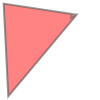

In [332]:
df.loc[23]['geometry']

In [340]:
# this is a triangle which has geometry problems
df.drop(23, inplace=True)

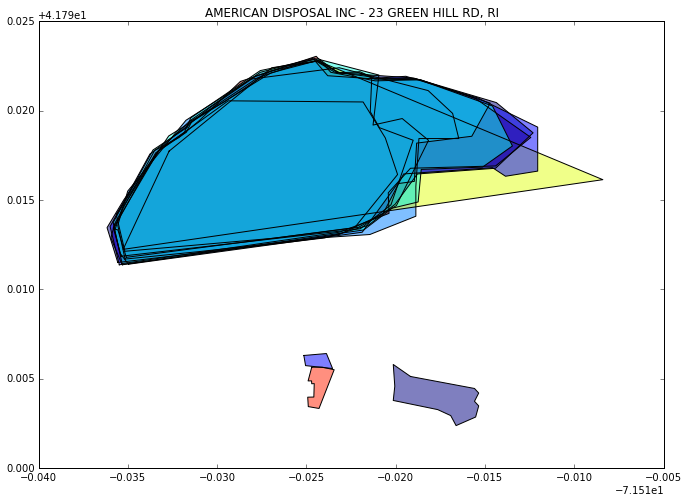

In [356]:
landfill = df[df['task_id'] == 501701]
landfill.plot()
title = landfill['fac_name'][0] + " - " + landfill['fac_street'][0] + ", " + landfill['fac_state'][0]
plt.title(title)
plt.savefig('../plots/example_overlay.png', dpi=200)

---

## The Dumb Answer

In [674]:
landfill_mean = df.groupby(['task_id'])['area'].mean()
total = landfill_mean.sum()

print 'Total Landfills Counted: %s' %(len(landfill_mean))
print 'Sum Total Area of Landfills: {:,.2f} m \n'.format(total)
print 'Largest Landfill: {:,.2f} m'.format(np.max(landfill_mean))
print 'Smallest Landfill: {:,.2f} m'.format(np.min(landfill_mean))
print 'Average Landfill Area: {:,.2f} m'.format(np.mean(landfill_mean))

Total Landfills Counted: 484
Sum Total Area of Landfills: 340,114,306.86 m 

Largest Landfill: 10,141,207.81 m
Smallest Landfill: 922.89 m
Average Landfill Area: 702,715.51 m


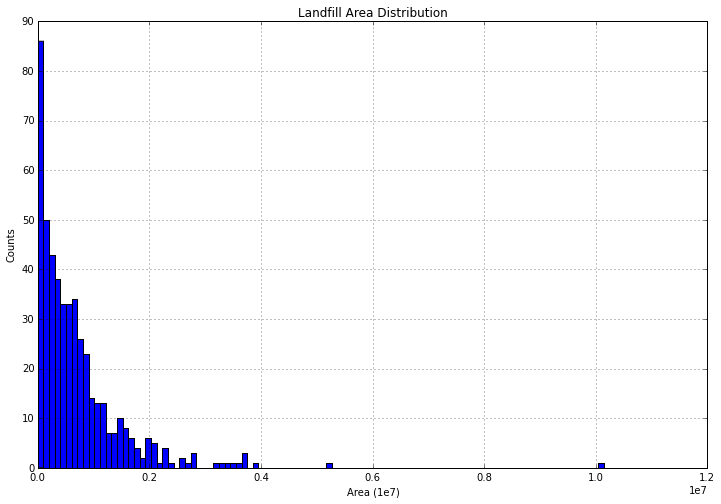

In [676]:
landfill_mean.hist(bins=100)
plt.title('Landfill Area Distribution')
plt.ylabel('Counts')
plt.xlabel('Area (1e7)')

## Working with multiple entries

In [459]:
task_len = df.groupby(['task_id']).size()
multiples = df[df['task_id'].isin(list(task_len[task_len > 1].reset_index()['task_id']))]

In [465]:
# Total Number of Polygons
print "Total number of task entries : %s" %(df.shape[0])
print "Total number of tasks with multiple entries : %s" %(multiples.shape[0])

Total number of task entries : 657
Total number of tasks with multiple entries : 228


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


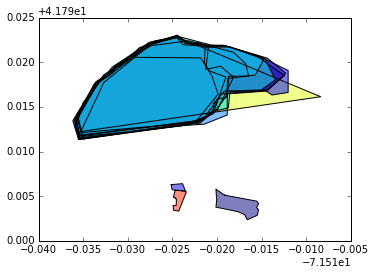

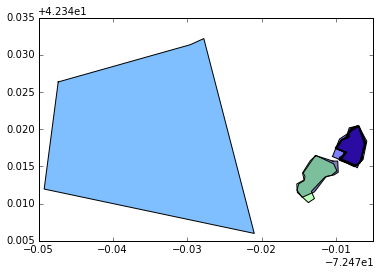

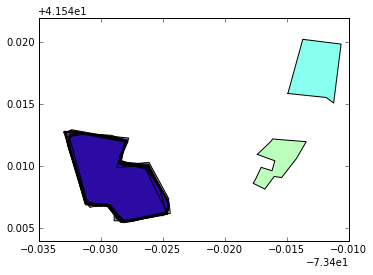

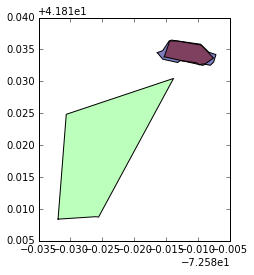

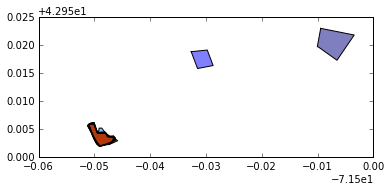

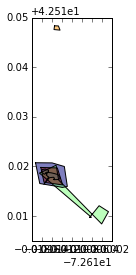

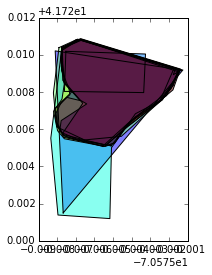

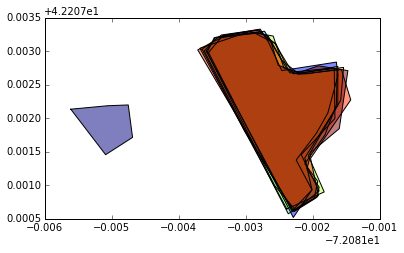

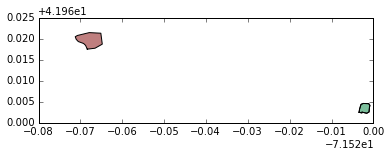

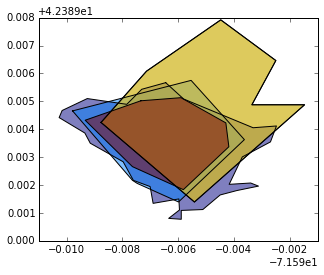

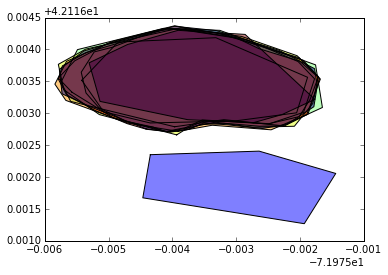

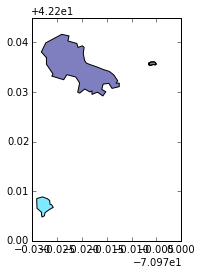

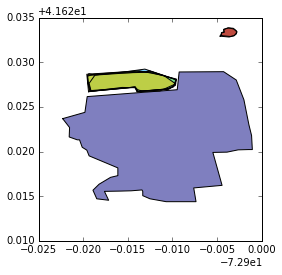

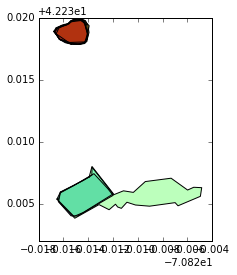

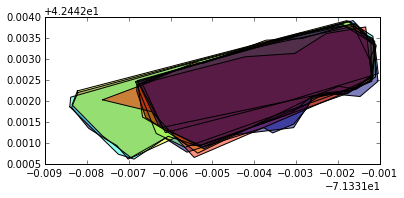

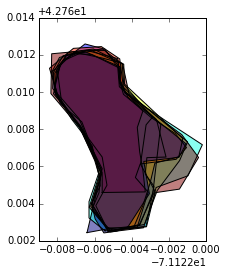

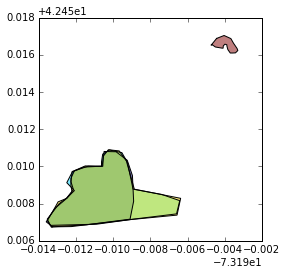

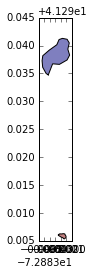

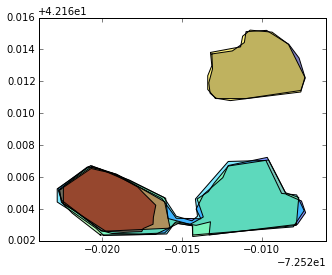

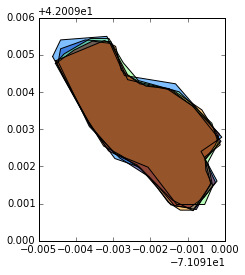

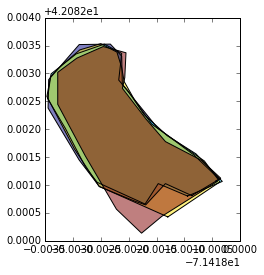

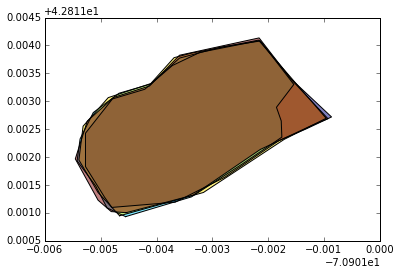

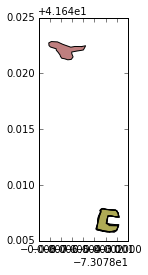

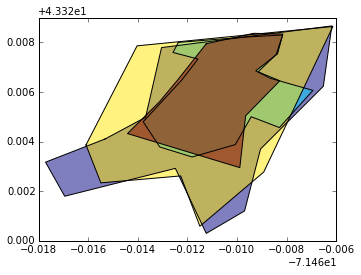

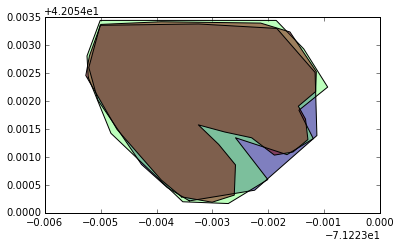

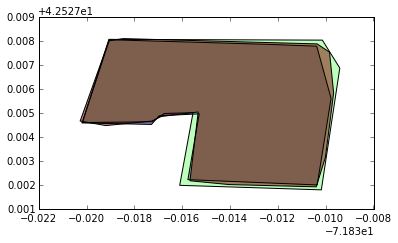

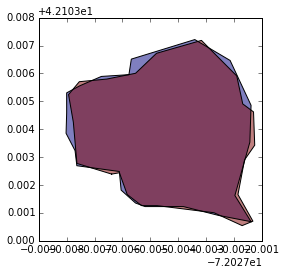

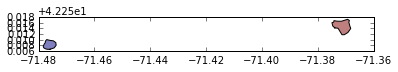

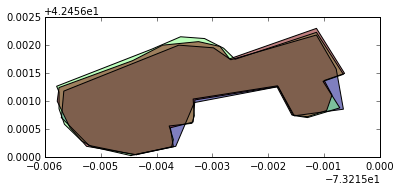

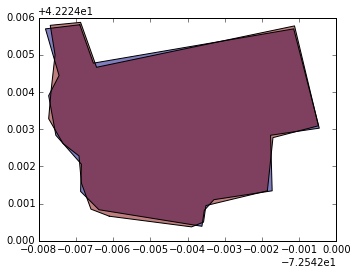

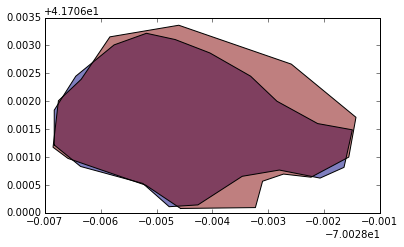

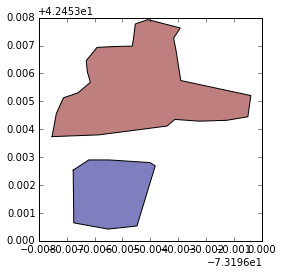

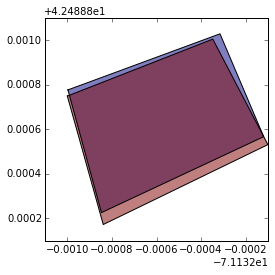

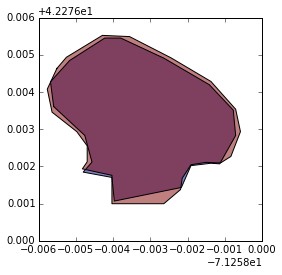

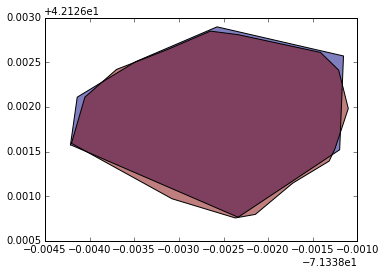

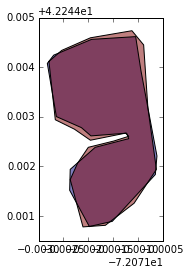

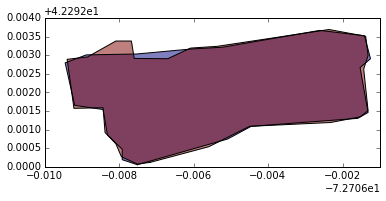

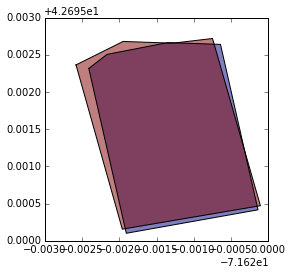

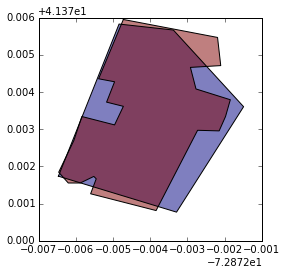

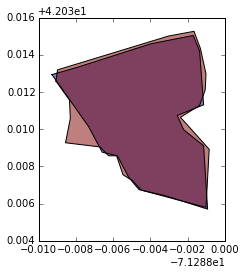

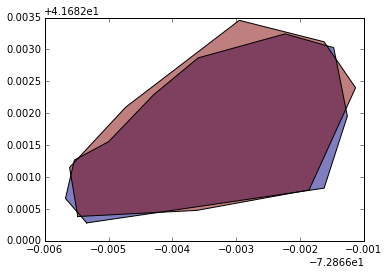

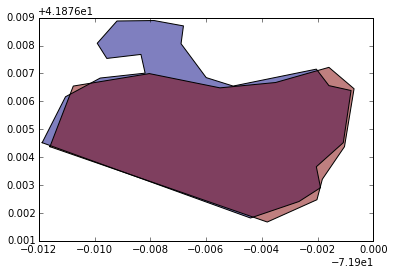

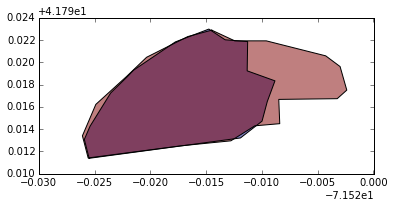

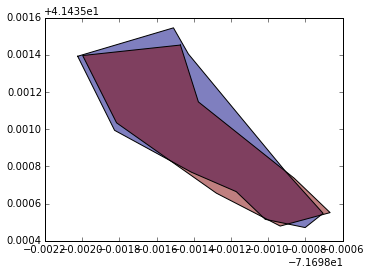

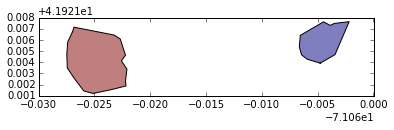

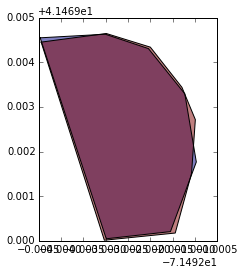

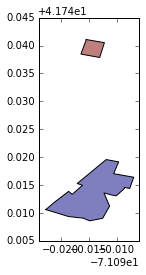

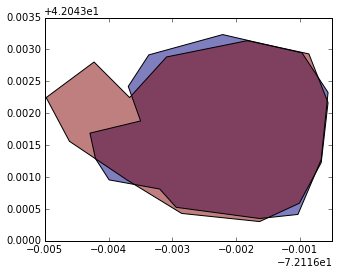

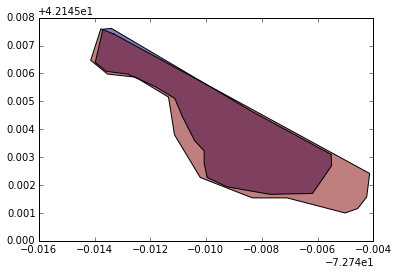

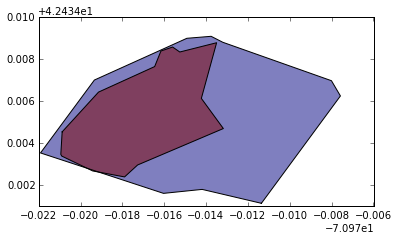

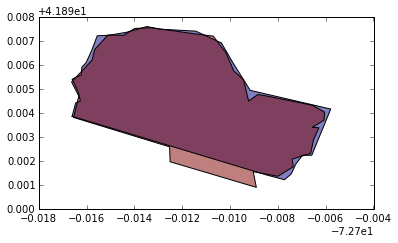

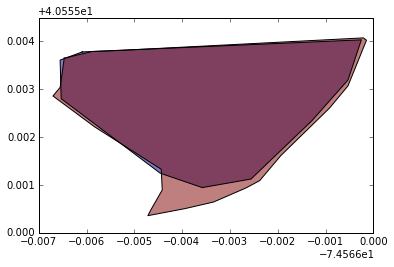

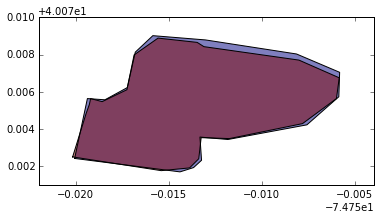

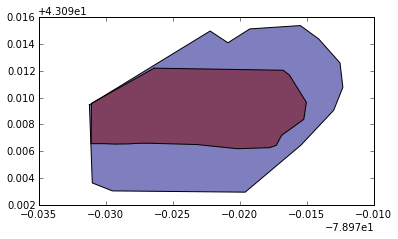

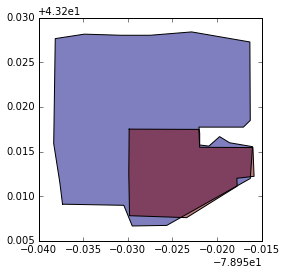

In [87]:
# Plot tasks with multiple entries
for ind, val in multiples.groupby('task_id'):
    val.plot()

In [381]:
def get_intersections(df):
    '''For each task_id group, create a list of indexes
    for landfills that intersect'''
    
    mask = {}
    for ind, val in df.iterrows():
        landfill = gp.GeoDataFrame(val)
        landfill['geometry'] = val['geometry']
        mask[ind] = []

        for ind1, val1 in df.iterrows():

            test_landfill = gp.GeoDataFrame(val1)
            test_landfill = val1['geometry']
            res = landfill.intersects(test_landfill)['task_id']
            if res:
                mask[ind].append(ind1)

    mask = [list(x) for x in set(tuple(x) for x in mask.values())]
    for i in mask:
        return i
    
#################################################

mask = []
for ind, val in df.groupby(['task_id']):
    if len(val) > 1:
        mask.append(get_intersections(val))

### Stats about groups of landfills

In [472]:
print "Number of non-overlapping polygons from tasks with multiple entries: %s" %(len(mask))
print "Number of overlapping polygons from tasks with multiple entries: %s" %(45)

Number of non-overlapping polygons from tasks with multiple entries: 55
Number of overlapping polygons from tasks with multiple entries: 45


In [625]:
stats = {}
for landfill_groups in mask:
    ind = df.loc[landfill_groups]['task_id'].unique()[0]
    stats[ind] = {'max': None, 'min': None, 'mean': None, 'std': None}
    
    stats[ind]['max'] = df.loc[landfill_groups]['area'].max()
    stats[ind]['min'] = df.loc[landfill_groups]['area'].min()    
    stats[ind]['mean'] = df.loc[landfill_groups]['area'].mean()
    stats[ind]['std'] = df.loc[landfill_groups]['area'].std()    

In [626]:
stats = pd.DataFrame(stats).T
stats.loc[501711] = np.nan

In [627]:
stats.describe()

max            mean             min             std
count       54.000000       54.000000       54.000000       44.000000
mean    295351.747359   241564.379402   186117.332657    86443.422094
std     566178.904425   387890.665647   238609.178560   304005.086826
min       3898.286807     3808.517042     3718.747278      126.953618
25%      53777.679863    52269.028305    50615.027102     2307.073312
50%     121383.795308   109789.704014    93474.761533     6054.827579
75%     330119.583642   270333.055509   211535.031876    29800.280353
max    3701305.316815  2332206.421711  1129670.078043  1936198.225685

In [634]:
# The average std deviation percentage
p = stats[stats['std'].notnull()]
p['std_pct'] = (p['mean'] / p['std'])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [637]:
# The average std is 24 but the standard deviation of that average is 26... not so good
p['std_pct'].describe()

count     44.000000
mean      24.163967
std       26.827315
min        1.204529
25%        7.122000
50%       15.639167
75%       30.022158
max      133.478364
Name: std_pct, dtype: float64

In [449]:
t_stats = stats[stats['std'] < 50000]

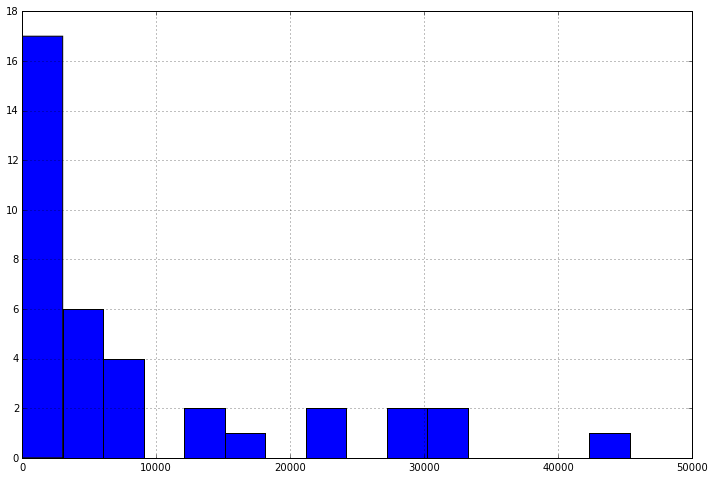

In [478]:
# distribution of standard deviations for each entry
t_stats['std'].hist(bins=15)

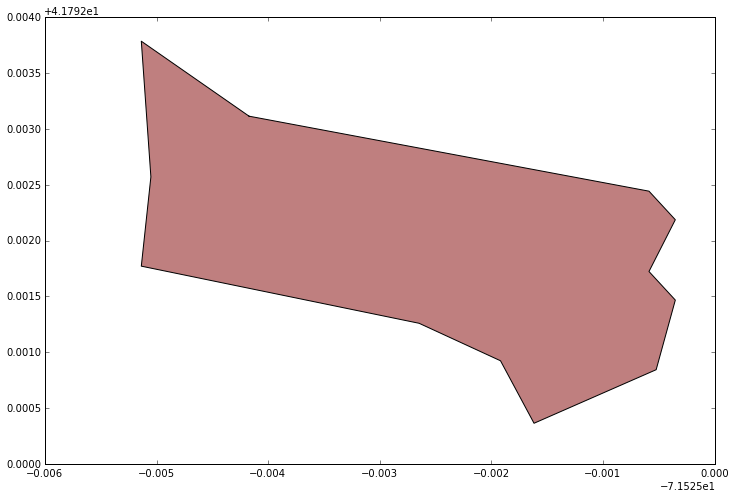

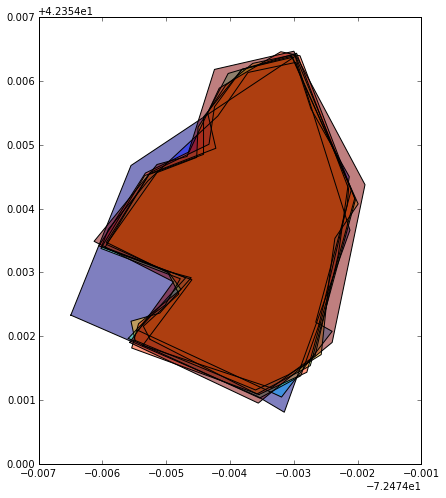

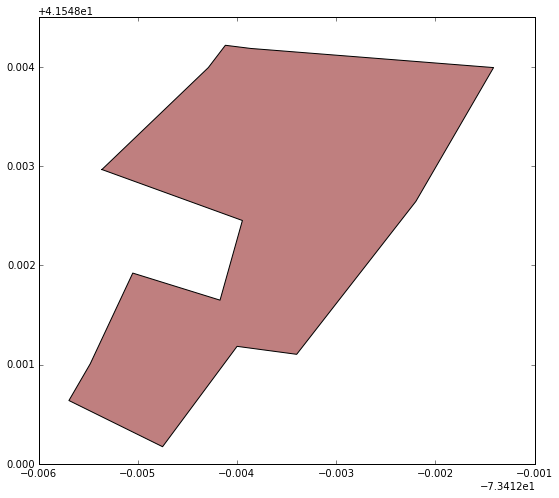

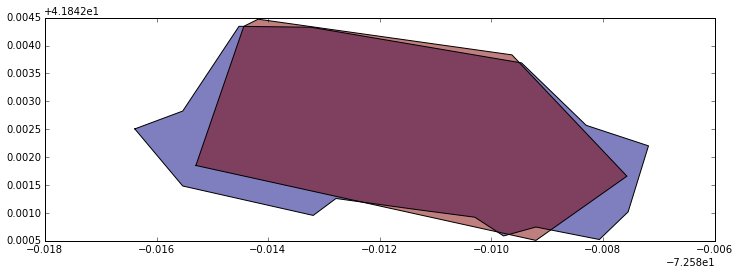

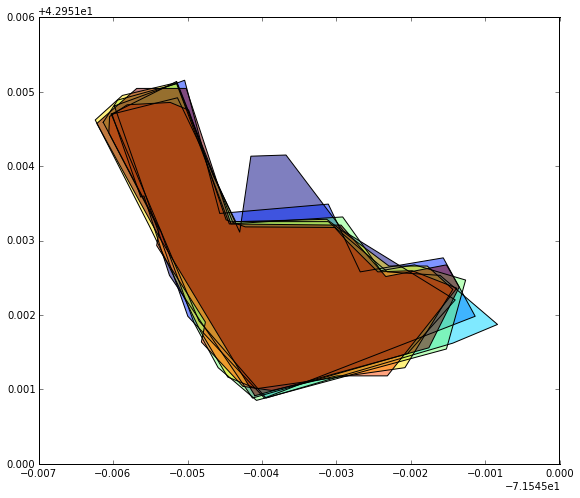

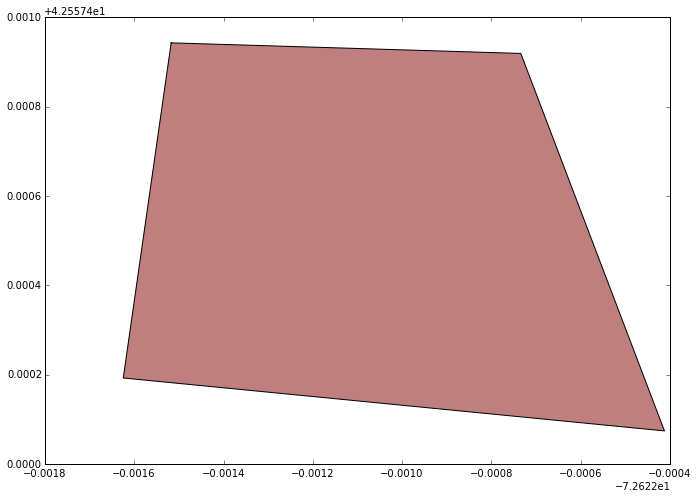

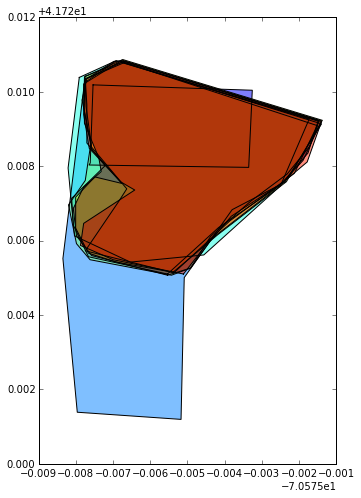

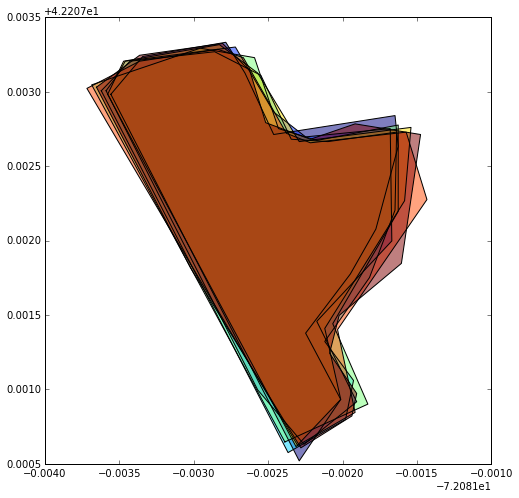

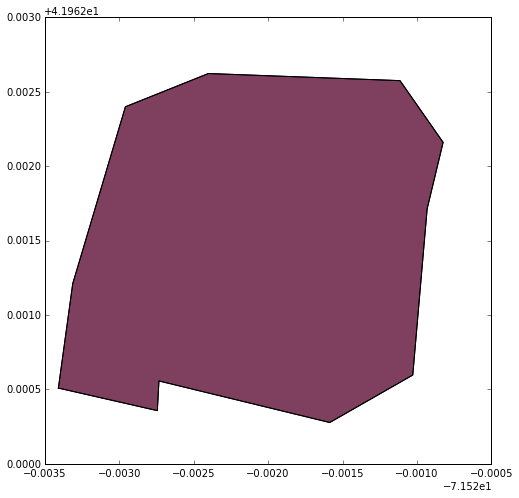

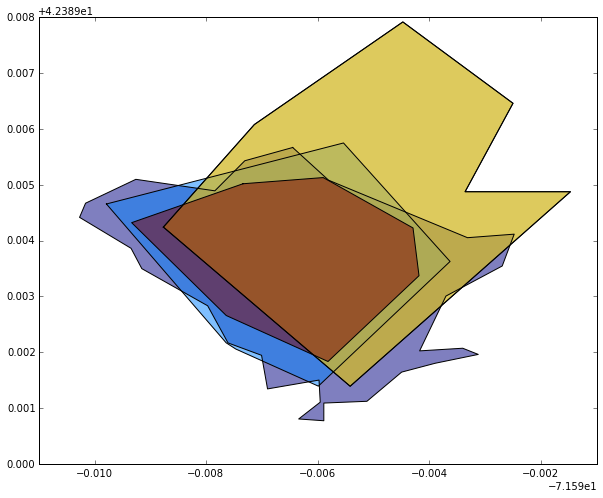

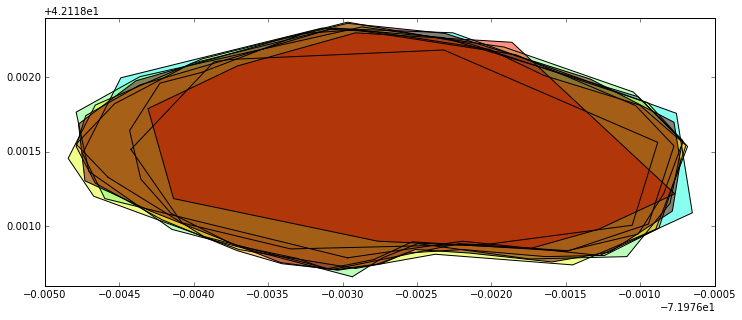

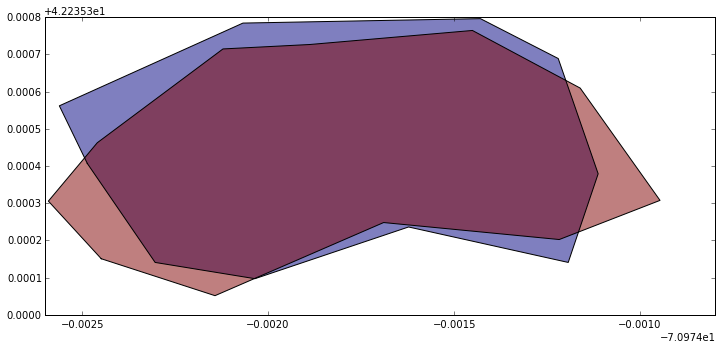

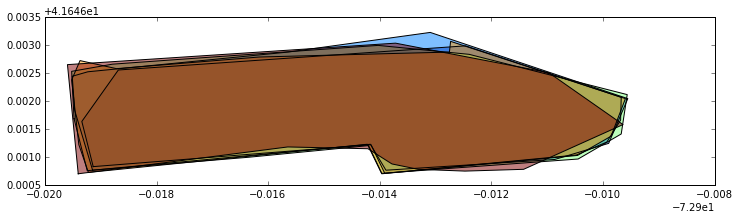

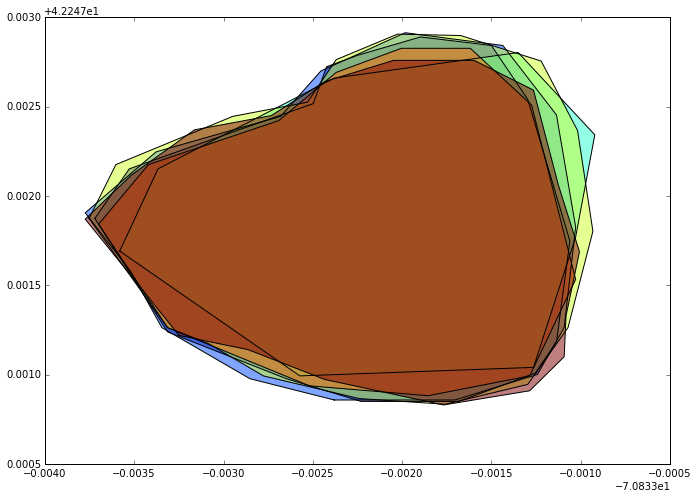

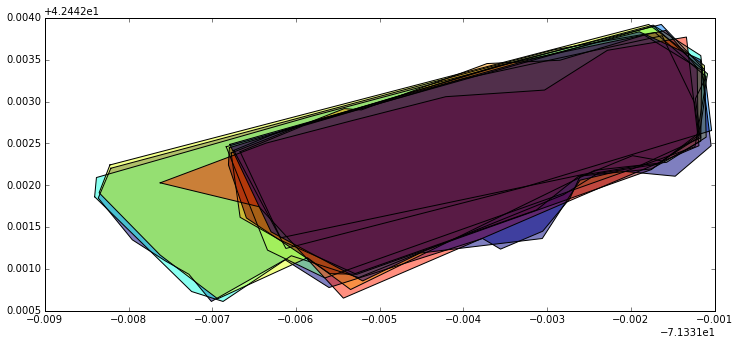

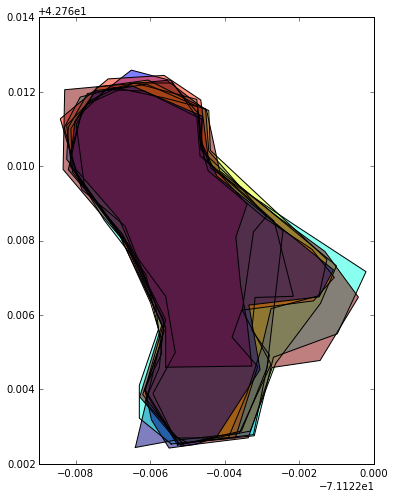

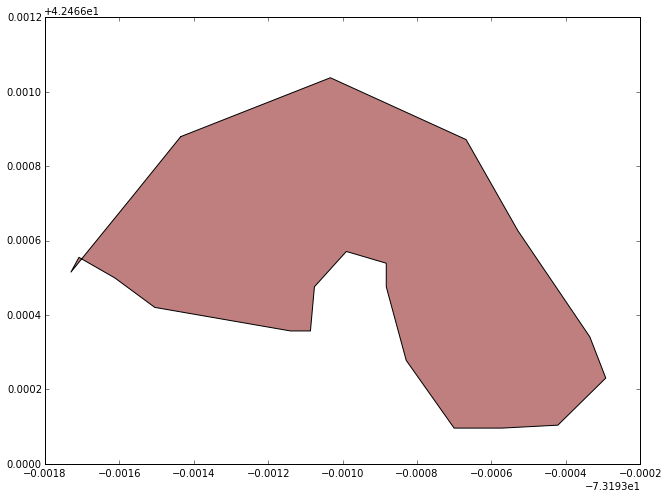

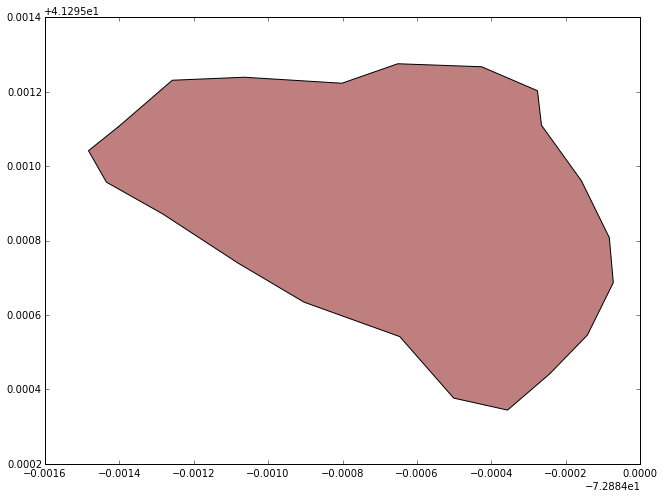

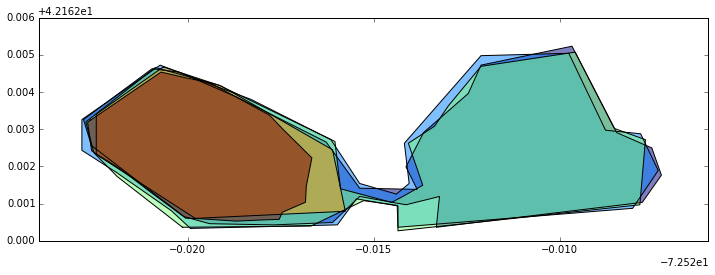

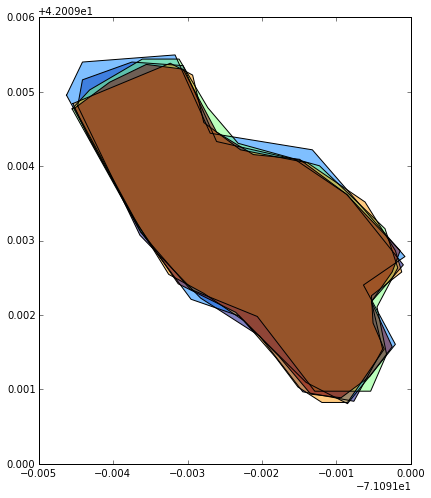

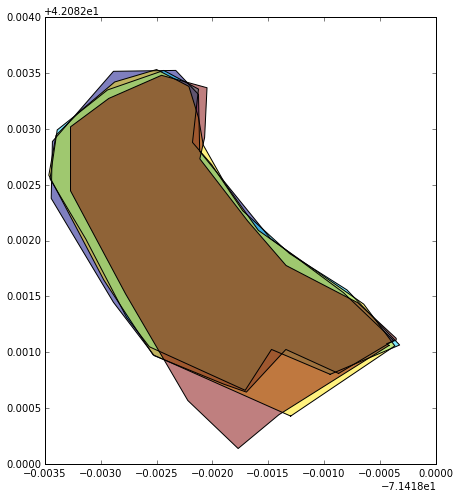

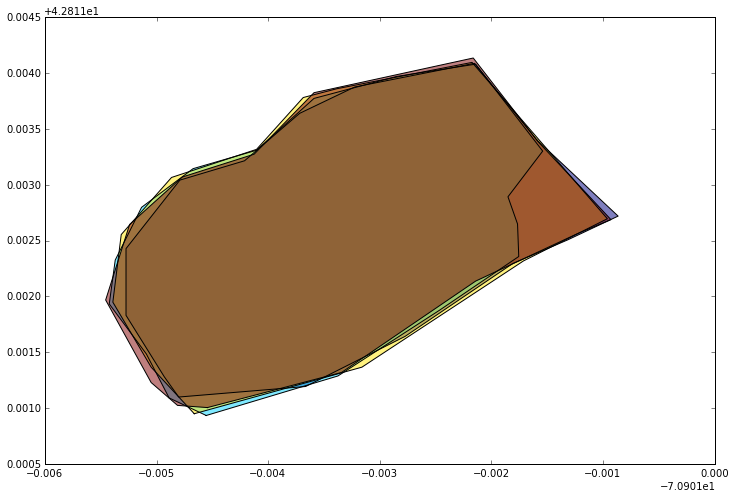

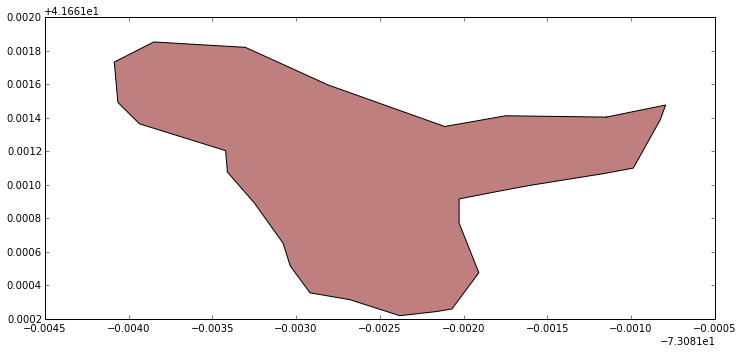

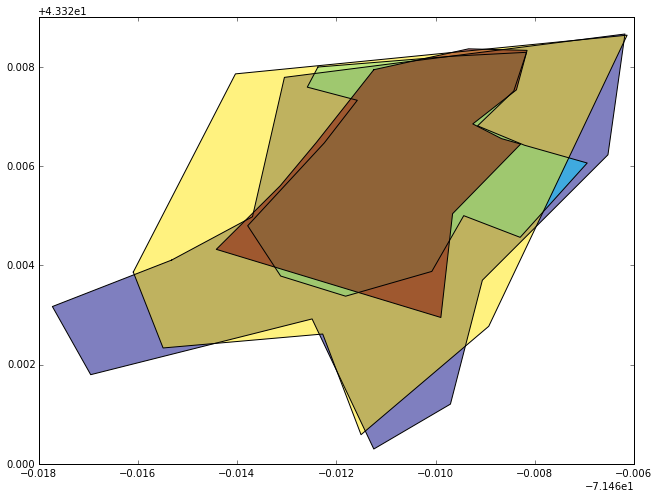

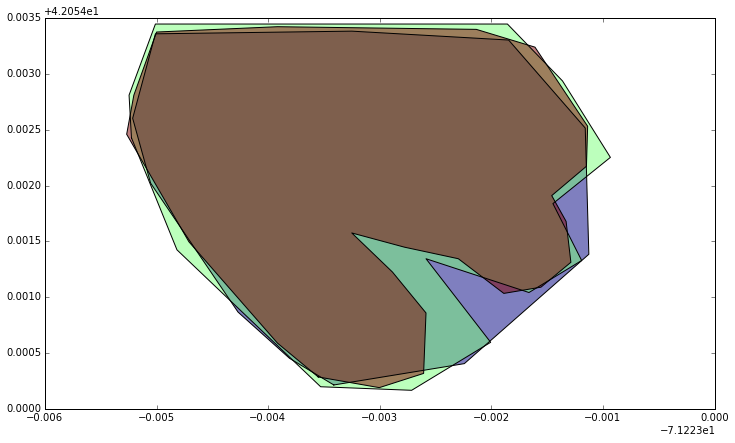

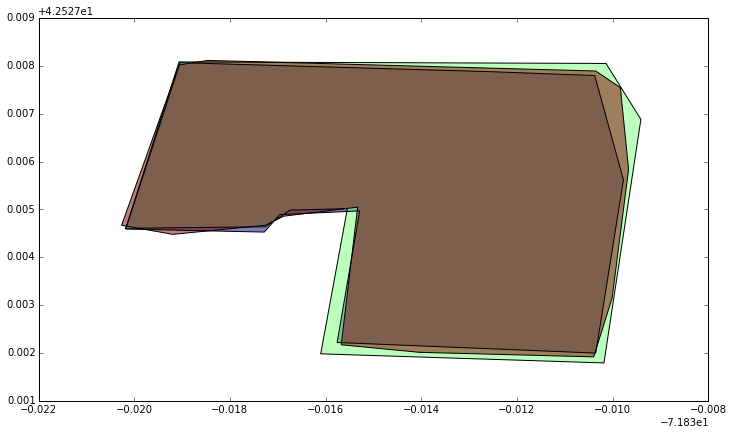

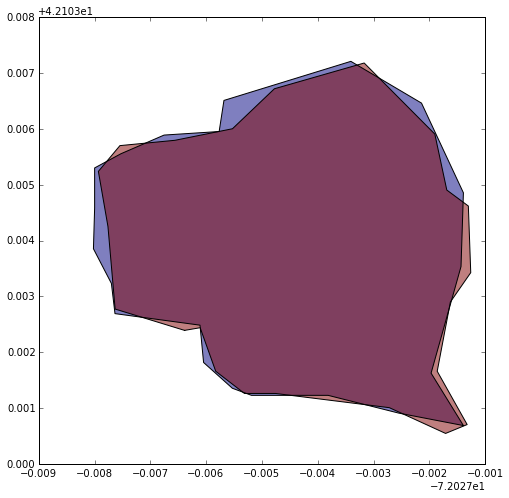

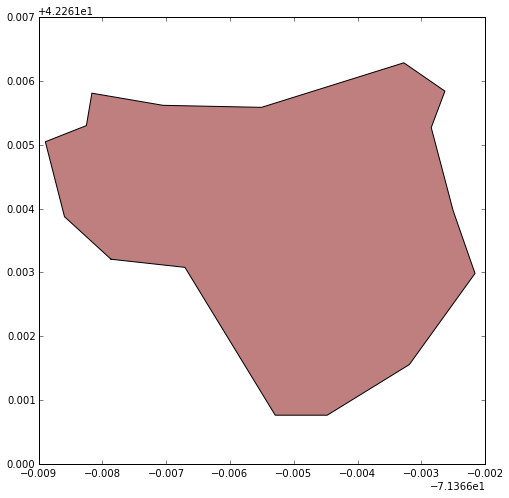

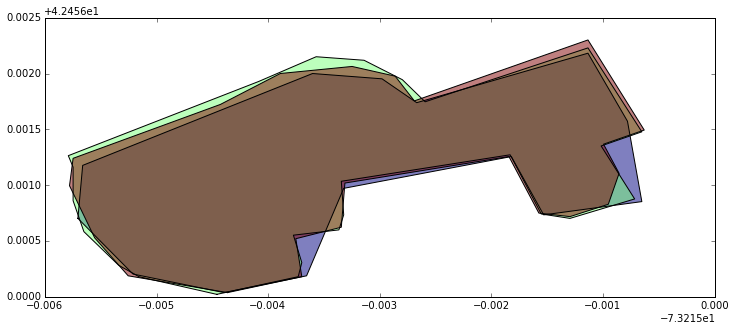

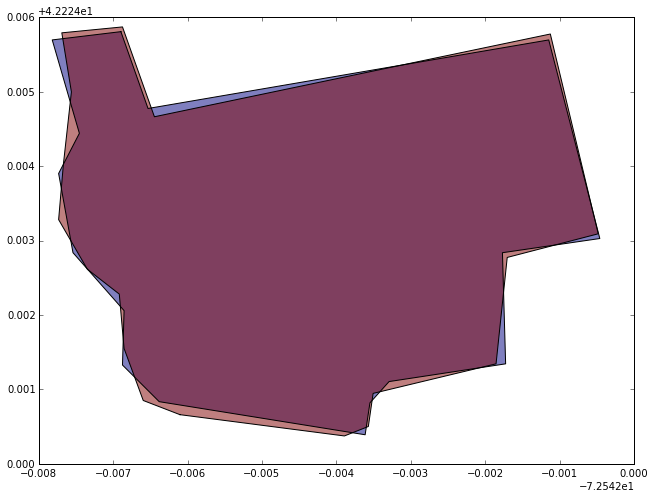

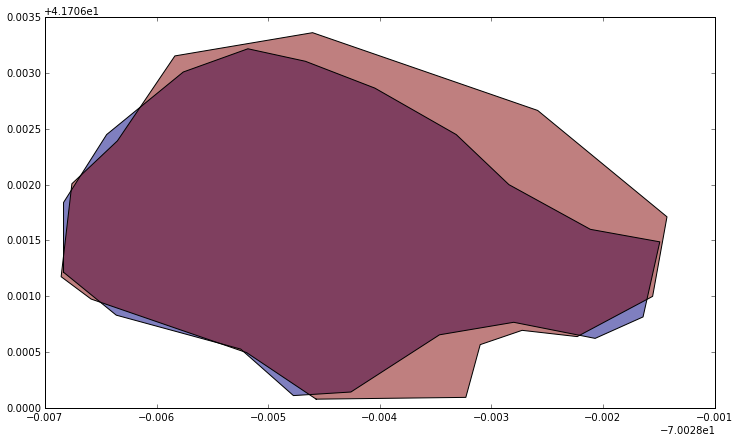

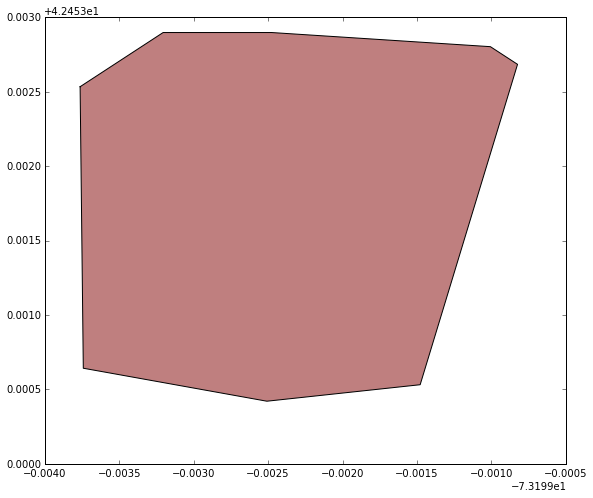

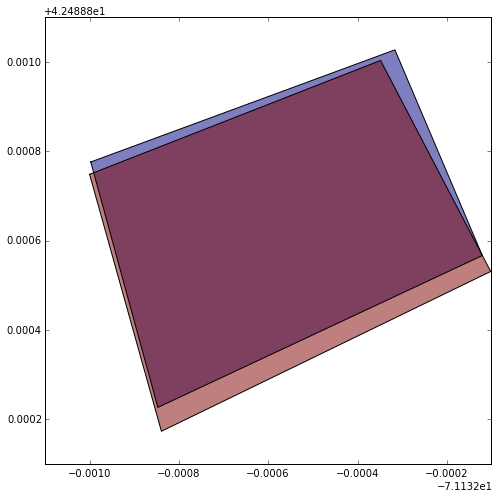

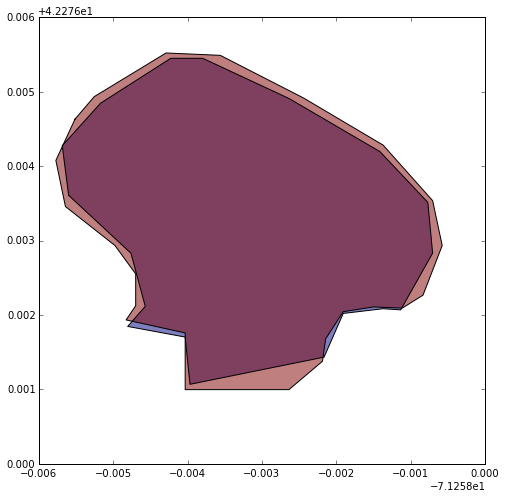

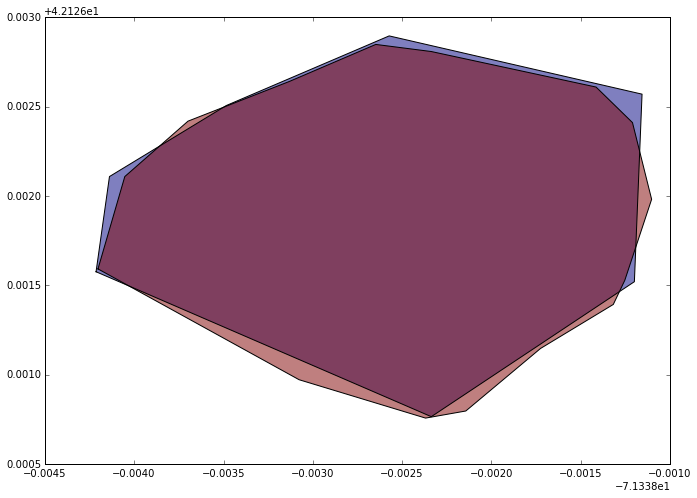

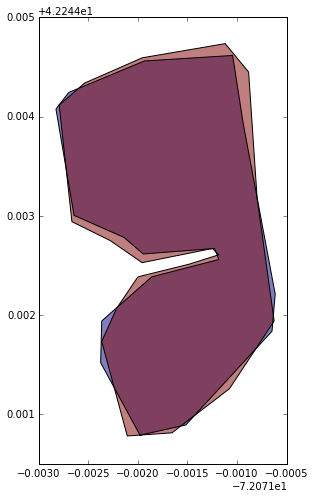

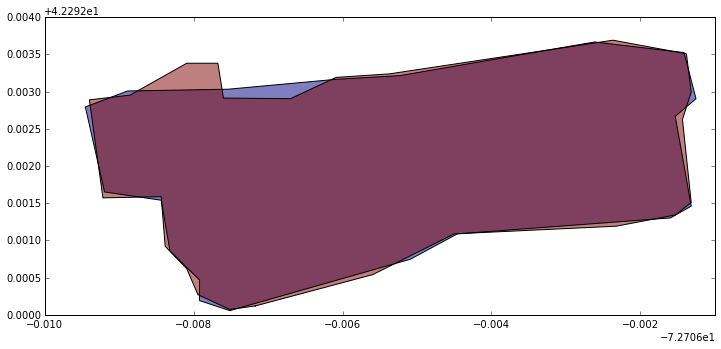

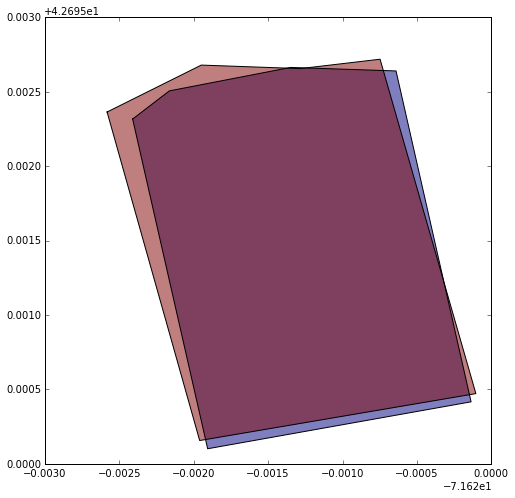

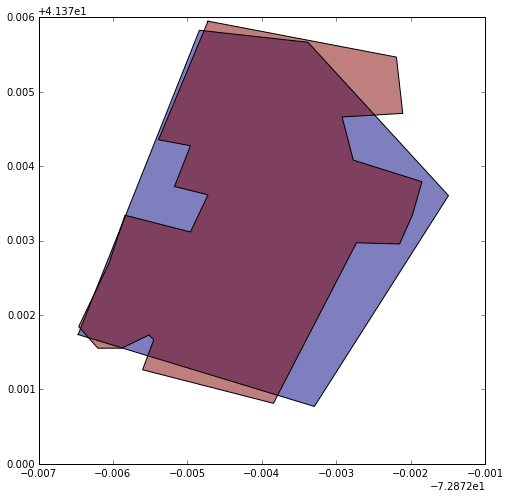

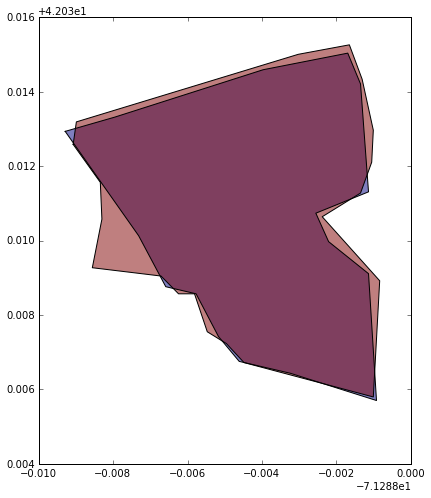

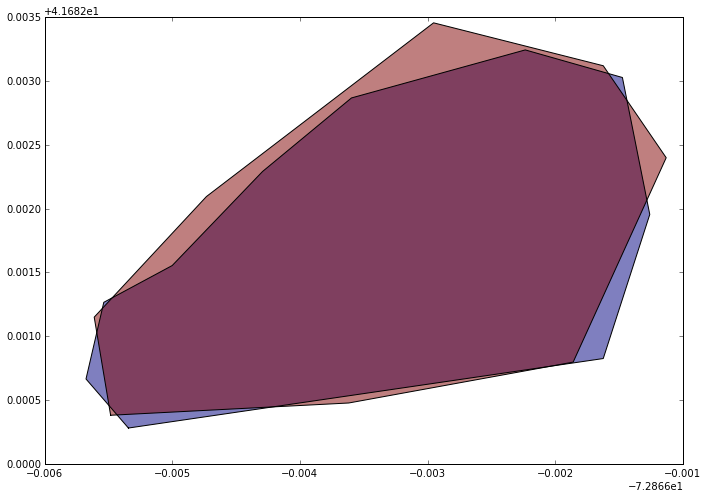

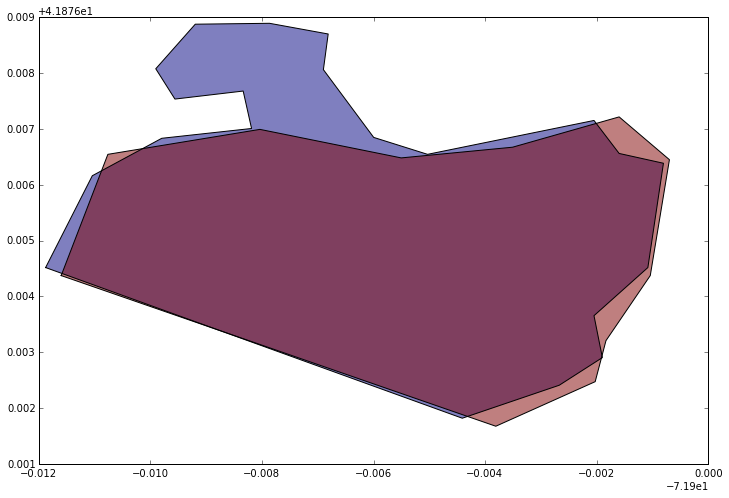

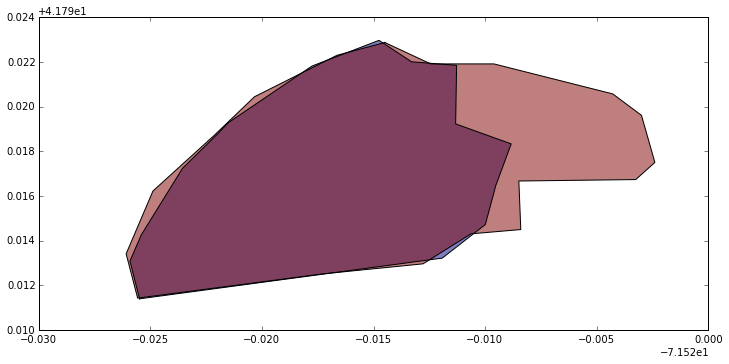

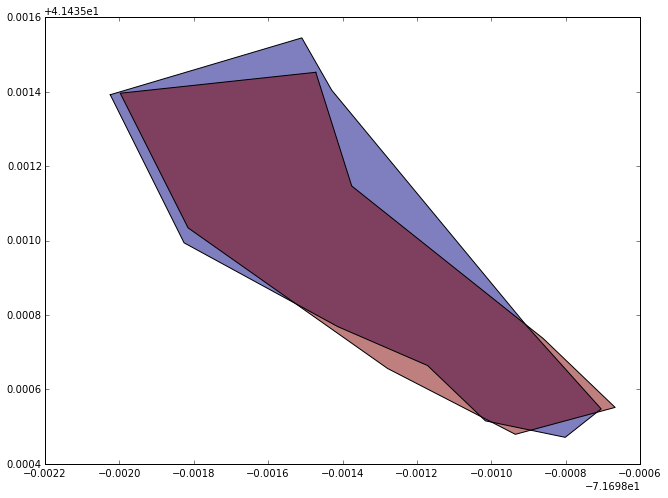

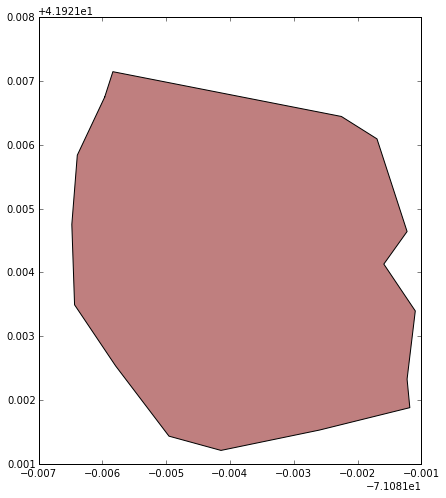

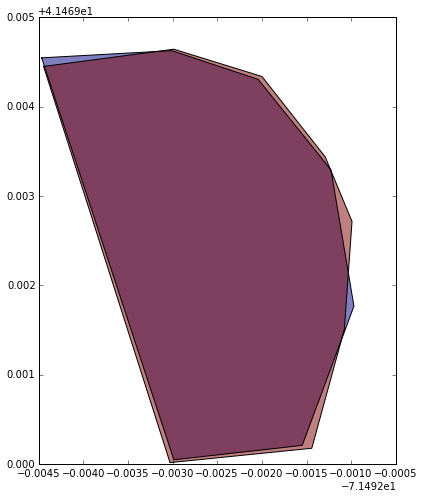

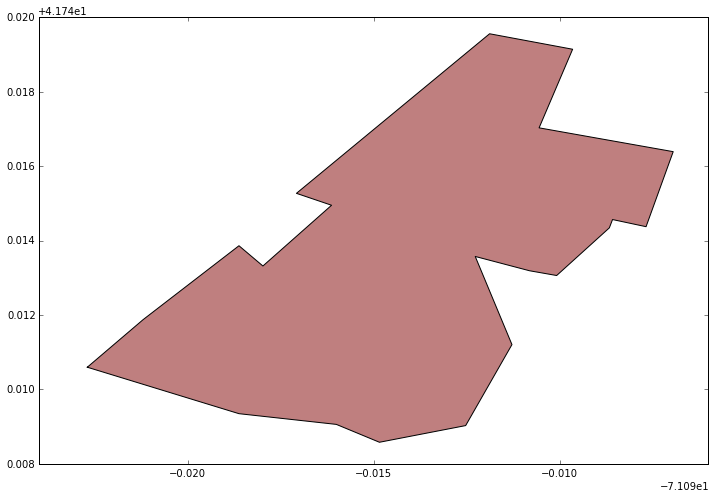

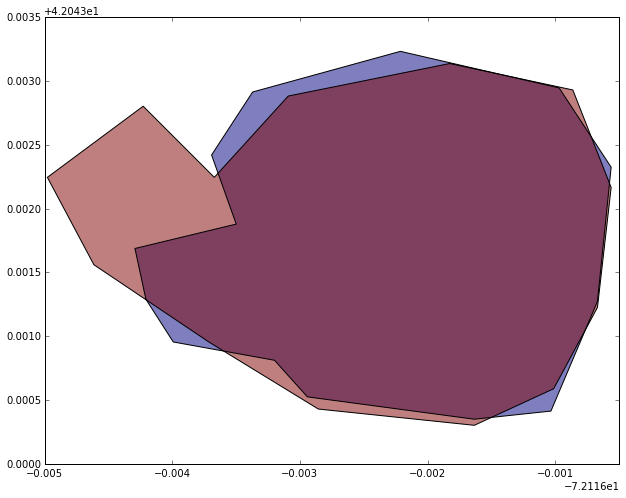

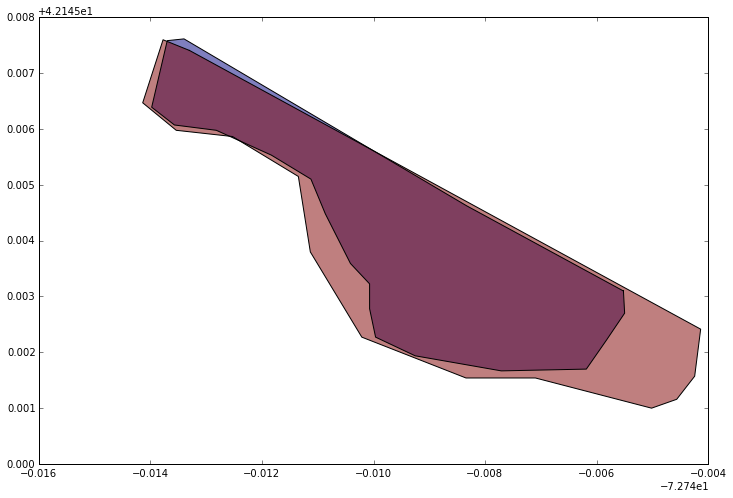

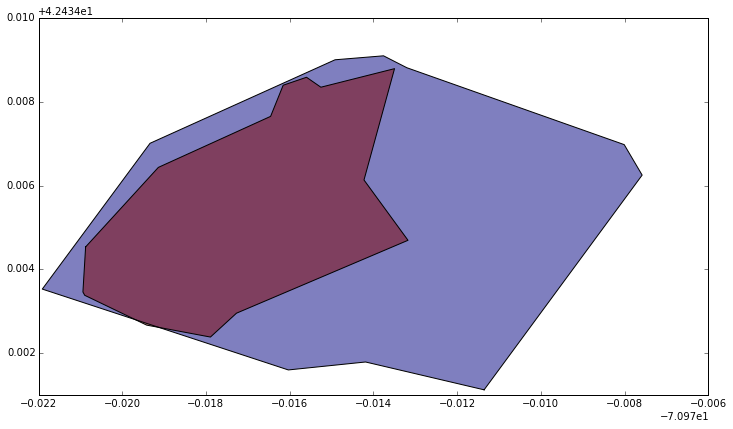

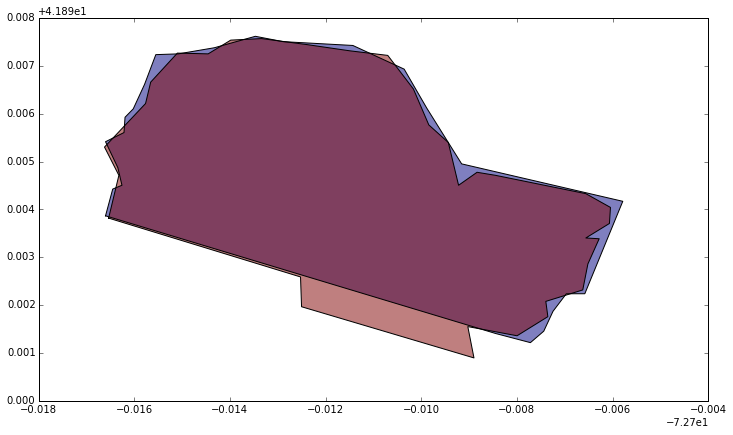

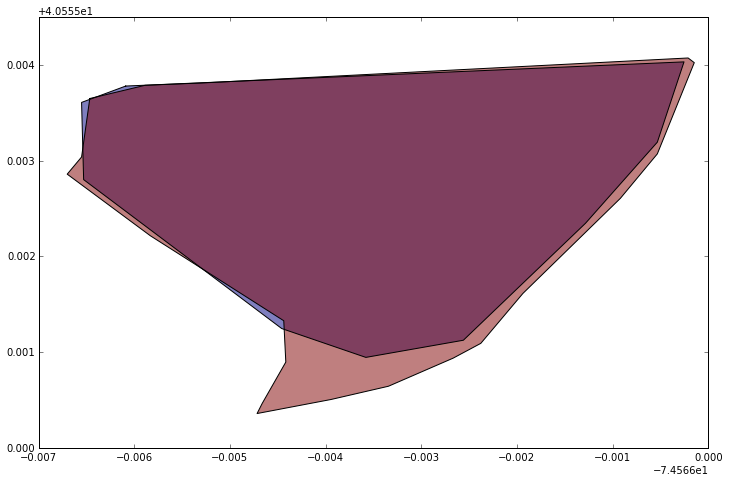

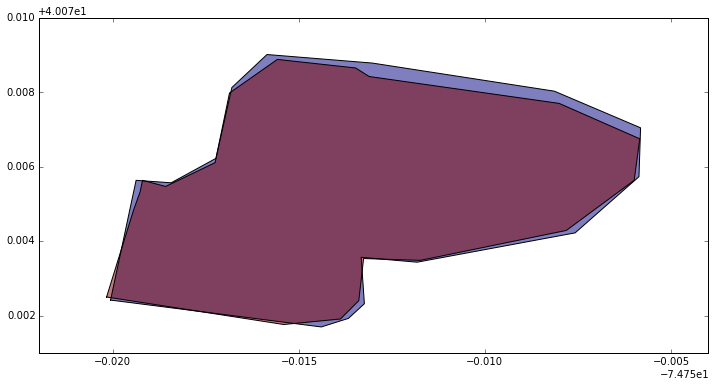

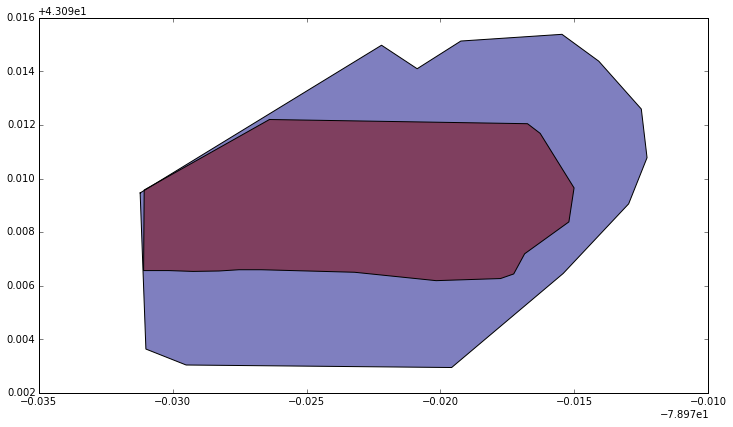

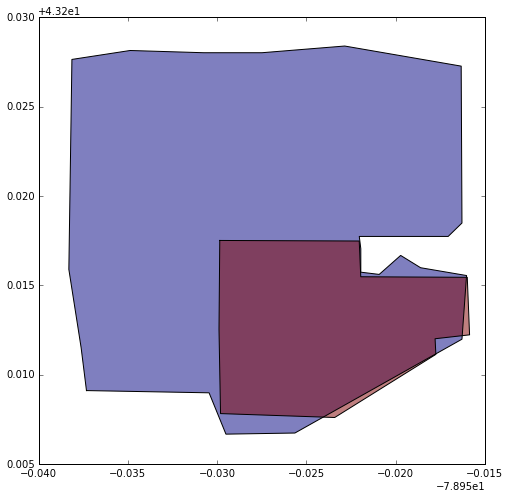

In [427]:
for landfill_groups in mask:
    df.loc[landfill_groups].plot()

In [481]:
# Overall average area for each entry
pd.pivot_table(df, index=['task_id'], values=['area'], aggfunc=np.mean).head()

area
task_id               
501701   986141.856586
501702   512871.805193
501703   283684.851809
501704   749860.464495
501706    88660.680029

In [37]:
area_std = [[ind, val['area'].std() * 3] for ind, val in df.groupby(['task_id'])]
area_std = dict(area_std)

## End Here

---

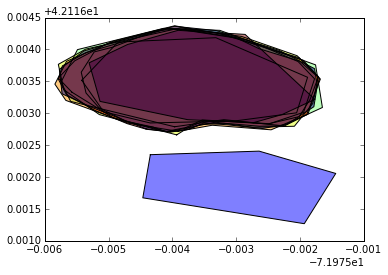

In [60]:
df[df['task_id'] == 501713].plot()

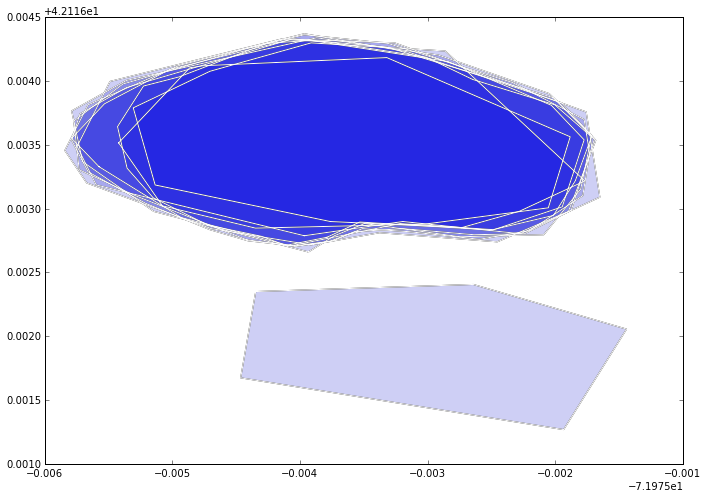

In [596]:
ax = df[df['task_id'] == 501713].plot()

for i in ax.patches:
    i.set_color("#111999")
    i.set_alpha(0.1)
    i.set_edgecolor("none")
#     i.set_linewidth(0)
#     i.set_joinstyle('bevel')
#     i.set_linestyle('dashed')


#ax.patches
for i in df[df['task_id'] == 501713]['geometry']:
    gp.plotting.plot_multipolygon(ax, i, alpha=0.1, facecolor='blue', edgecolor='white')
    
#edgecolor='white', alpha=0.1, facecolor='red', linewidth=0    


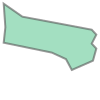

In [208]:
# show single geometry
df['geometry'][0]

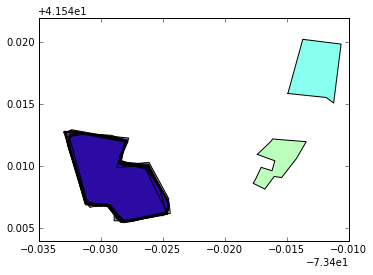

In [210]:
df[df['task_id'] == 501703].plot()
plt.show()

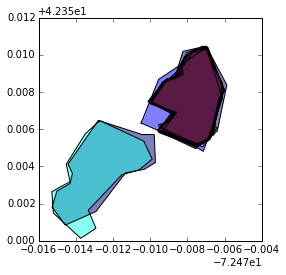

In [216]:
df[df['task_id'] == 501702][df['area'] < df['area'].std() * 3].plot()

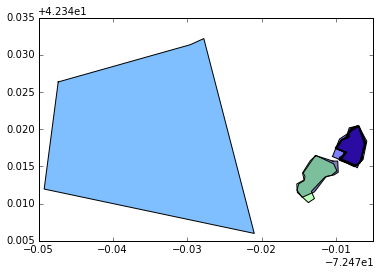

In [211]:
df[df['task_id'] == 501702].plot()
plt.show()

In [59]:
ax = df[df['task_id'] == 501713].plot()

mplleaflet.show(fig=ax.figure)

In [203]:
import mplleaflet
ax = lf.plot()
mplleaflet.show(fig=ax.figure)

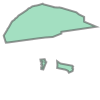

In [190]:
from shapely.ops import cascaded_union
cascaded_union(lf['geometry'])